<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#%load_ext autoreload
%matplotlib inline
#%autoreload 2

import sys
from IPython.display import clear_output
# sys.path.append('/eos/user/e/efthymio/Projects/LHCLumi/LHCLumiAnalysis/')
#for p in sys.path:
#    print (p)

import os
import cl2pd
from cl2pd import importData
pd = importData.pd
cals = importData.cals

# import LHCPerformanceTools.LHC_WSData as WSData
# WS = WSData.LHCWSData()

import itertools
import operator
import numpy as np
import glob
import pickle
import gzip
import time

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
from scipy.stats.stats import pearsonr 
from itertools import cycle
pd.options.mode.chained_assignment = None  # default='warn'


# get_ipython().magic('matplotlib inline')

# --- Definitions

BASEWSDIR = '/eos/project/l/lhc-profiles-lumi/WS/2018'
RAWWSDIR = '{}/rawdata'.format(BASEWSDIR)
PROCWSDIR = '{}/procdata'.format(BASEWSDIR)

MASS_PROTON = 938.27231 #MeV

# Extract Data and Do Fitting

Opens up all DataFrames of injection data in the fill range and concatenates them together.

In [3]:
problematic_fills = [6657, 6678, 6682, 6684, 6698, 6699, 6713, 6727, 6735, 6736, 6737, 6740, 6748,
                     6749, 6757, 6760, 6765, 6775, 6778, 6791, 6797, 6798, 6799, 6838, 6847, 6853, 6855, 6856,
                     6854, 6864, 6867, 6868, 6880, 6882, 6884, 6885, 6887, 6890, 6891, 6892, 6898, 6903, 6904]

fills = range(6639,6961)
fill_list = []

for fno in fills:
    
    if fno in problematic_fills:
        continue
    
    try:
        fname = '/eos/project/l/lhc-profiles-lumi/WS/2018/procdata/fill_{}/fill_{}_wsprof_exp.pkl'.format(fno, fno)
        with open(fname,'rb') as fin:
            myFill = importData.LHCFillsByNumber(fno)
            t1 = myFill[myFill['mode']=='INJPROT']['startTime'][0]
            t2 = myFill[myFill['mode']=='INJPHYS']['endTime'][0]
            
            temp_df = pd.read_pickle(fin)
            fill_list.append(temp_df[(temp_df.index > t1) & (temp_df.index < t2)]) #only during injection
    except:
        continue
        
scandf = pd.concat(fill_list)

## Convert All Data to NumPy Arrays

To whomever is reading this, not all data for all fills is stored in numpy arrays; some use different datatypes. This is bad programming. Regardless, I now convert all data to NumPy arrays.

In [4]:
scandf['PROF_DATA_IN'] = scandf['PROF_DATA_IN'].apply(lambda x: np.array(x))
scandf['PROF_DATA_OUT'] = scandf['PROF_DATA_OUT'].apply(lambda x: np.array(x))
scandf['PROF_POSITION_IN'] = scandf['PROF_POSITION_IN'].apply(lambda x: np.array(x))
scandf['PROF_POSITION_OUT'] = scandf['PROF_POSITION_OUT'].apply(lambda x: np.array(x))

## Fit Gaussian Parameters to Get Width

Fit data to

$ f(x) = ae^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2}$

and use $\sigma$ as beam width.

In [5]:
def gaus(x, sigma, x0, a, y0):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + y0

In [6]:
def fit_to_gauss(df_row, wire_movement):

    x = df_row['PROF_POSITION_'+wire_movement]
    y = df_row['PROF_DATA_'+wire_movement]
    
    # INITIAL GUESSES FOR FIT
    ypeak = max(y) 
    xpeak = 0
    half_max = np.abs(y-ypeak/2).argmin()
    std_approx = np.abs(x[half_max] - xpeak)
    
    if ypeak>200:
        popt,pcov = scipy.optimize.curve_fit(gaus,x,y,p0=[std_approx, xpeak, ypeak, 0])
        sigma, mean, ampl, yoff = popt 
    else:
        mean = ampl = yoff = 0
        sigma = None
        
    return sigma

In [7]:
scandf['BEAM_WIDTH_IN'] = scandf.apply(fit_to_gauss, axis='columns', args=('IN',))
scandf['BEAM_WIDTH_OUT'] = scandf.apply(fit_to_gauss, axis='columns', args=('OUT',))

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Set Appropriate Beta Values

Given by Dr. Efthymiopoulos

In [8]:
def get_beta(df_row):
    
    BEAM_NUM = str(df_row['BEAM'])
    POS = str(df_row['PLANE'])
    
    if BEAM_NUM == 'B1' and POS == 'V':
        inj_beta, flattop_beta, squeeze_beta = 342.1, 337.5, 333.4
    if BEAM_NUM == 'B1' and POS == 'H':
        inj_beta, flattop_beta, squeeze_beta = 193.4, 183.3, 193.2
    if BEAM_NUM == 'B2' and POS == 'V':
        inj_beta, flattop_beta, squeeze_beta = 396.6, 421.1, 408.3
    if BEAM_NUM == 'B2' and POS == 'H':
        inj_beta, flattop_beta, squeeze_beta = 185.3, 187.7, 182.3
    
    return inj_beta

In [9]:
scandf['BETA'] = scandf.apply(get_beta, axis='columns')
scandf = scandf.dropna()

## Set Appropriate Emittance Values

$\epsilon_N = \frac{E}{m}\frac{\sigma^2}{\beta}$

In [10]:
def get_emit(df_row, wire_movement):
    return (df_row['BEAM_WIDTH_'+wire_movement]**2 *
            (df_row['ENERGY']) /
            (df_row['BETA'] * MASS_PROTON))*10**-3

In [11]:
scandf['EMIT_IN'] = scandf.apply(get_emit, axis='columns', args=('IN',))
scandf['EMIT_OUT'] = scandf.apply(get_emit, axis='columns', args=('OUT',))

## Set Appropriate Brightness Values

$B=\frac{\epsilon_N}{I}$

In [12]:
def get_bright(df_row, wire_movement):
    if df_row['INTENSITY']>0:
        return df_row['EMIT_'+wire_movement]/df_row['INTENSITY']
    else:
        return None

In [13]:
scandf['BRIGHT_IN'] = scandf.apply(get_bright, axis='columns', args=('IN',))
scandf['BRIGHT_OUT'] = scandf.apply(get_bright, axis='columns', args=('OUT',))
scandf = scandf.dropna()

# Plotting

First lets change all the bunch and fill numbers from floats to ints; this makes plotting look nicer

In [14]:
scandf['BUNCH'] = scandf['BUNCH'].apply(lambda x: int(x))
scandf['FILL'] = scandf['FILL'].apply(lambda x: int(x))

## Emittance During Injection for All Bunches

The plots below examine the emittance distribution for all fills during the injection phase. The emittances of all bunches are used for these distributions. The emittance was obtained using the same method as before; the beam width was determined by fitting wire scanner beam profiles to normal curves and this was used to calculate $\epsilon_N$. Both the IN and OUT measurements are shown.

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:637: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:885: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/seaborn/categorical.py:905: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


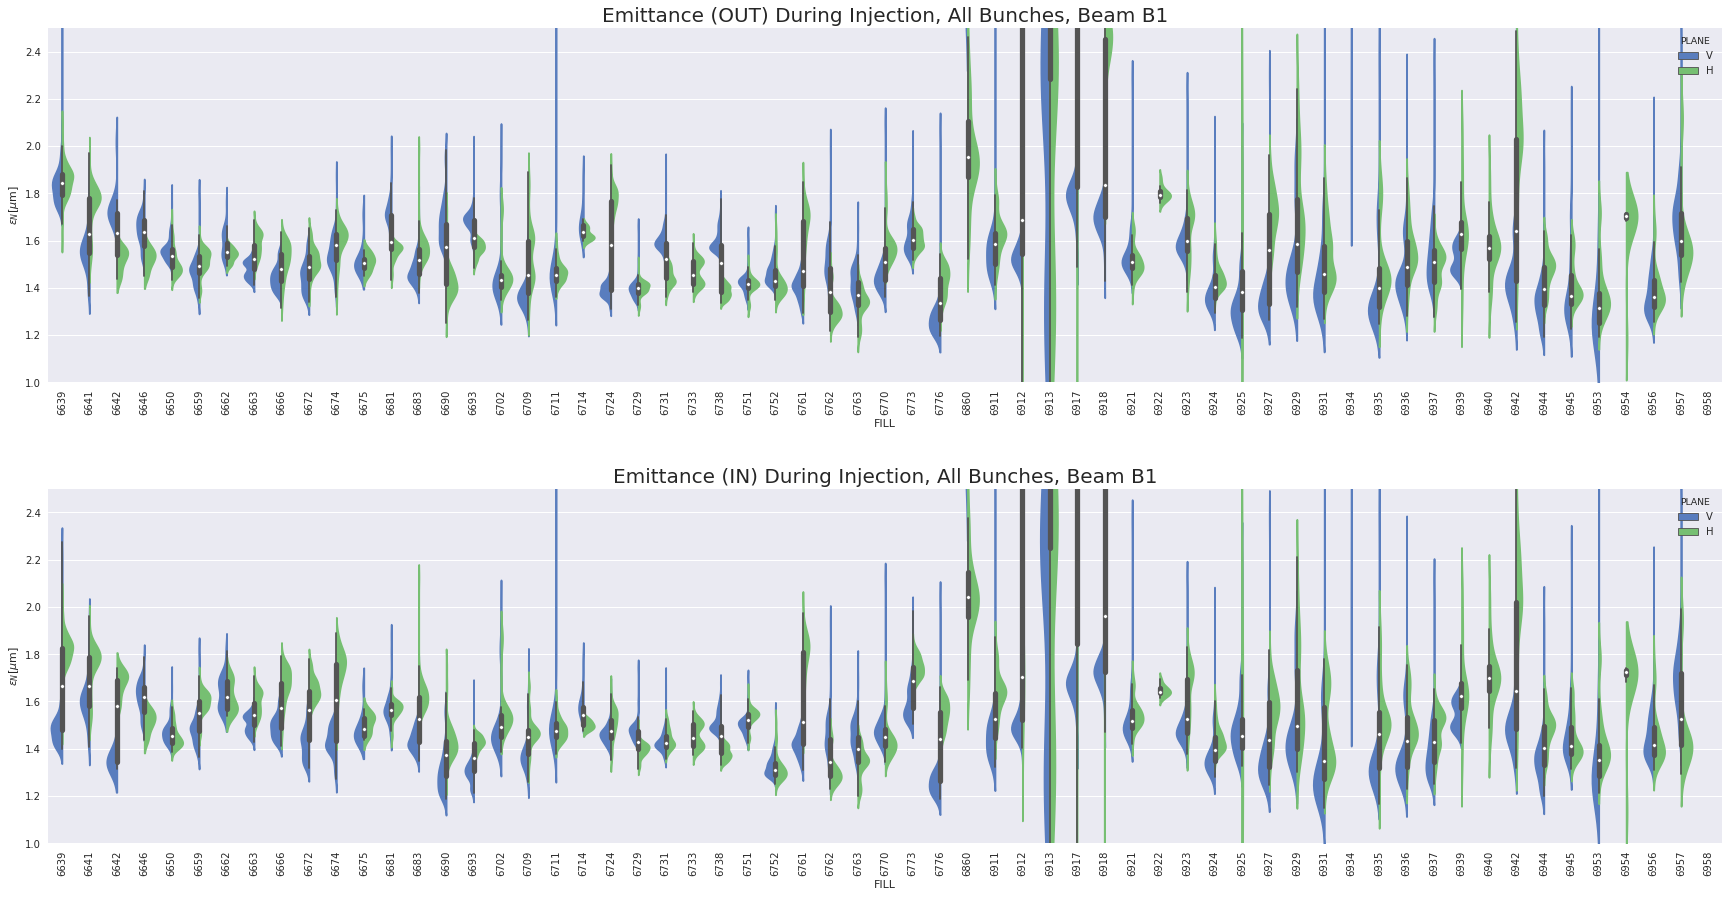

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(30,15))
fig.subplots_adjust(hspace=0.3)
sns.set(style="whitegrid")
beam = 'B1'

axs[0] = sns.violinplot(x='FILL', y='EMIT_OUT', hue='PLANE',
                  data=scandf[scandf['BEAM']==beam], palette="muted", split=True, ax=axs[0])
axs[0].set_ylim(1, 2.5)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title('Emittance (OUT) During Injection, All Bunches, Beam {}'.format(beam), FONTSIZE=20)
axs[0].set_ylabel(r'$\epsilon_N [\mu$m]')

axs[1]=sns.violinplot(x='FILL', y='EMIT_IN', hue='PLANE',
                  data=scandf[scandf['BEAM']==beam], palette="muted", split=True, ax=axs[1])
axs[1].set_ylim(1, 2.5)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[1].set_title('Emittance (IN) During Injection, All Bunches, Beam {}'.format(beam), FONTSIZE=20)
axs[1].set_ylabel(r'$\epsilon_N [\mu$m]')

plt.savefig('emittance_all_fills_B2.pdf', bbox_inches='tight')

## Examine A Bad Beam Profile

Occasionally the IN and OUT measurements significantly disagree with each other; this is most likely due to errors in the wire scanner measurement. For Fill 6642, Plane V, the IN-OUT measurements are consistent for B2 but significantly inconsistent for B1. The plot below examines sample beam profile from B1. The data shown is raw data (not Gaussian fits).

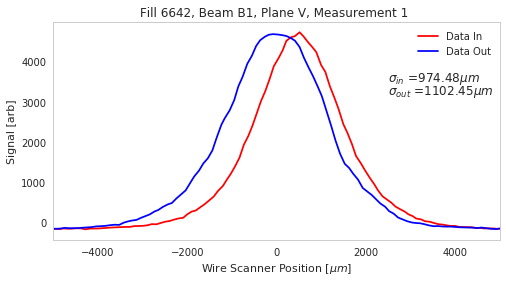

In [16]:
n = 1
fill_num = 6642
plane = 'V'
beam = 'B1'

testdf = scandf[(scandf['FILL']== fill_num) & (scandf['PLANE']==plane) & (scandf['BEAM']==beam)]
x1 = testdf.iloc[n]['PROF_POSITION_IN']
x2 = testdf.iloc[n]['PROF_POSITION_OUT']
y1 = testdf.iloc[n]['PROF_DATA_IN']
y2 = testdf.iloc[n]['PROF_DATA_OUT']

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x1, y1, color='r', label='Data In')
ax.plot(x2, y2, color='b', label='Data Out')
plt.xlim([-5000,5000])

plt.text(2500, 3500, r'$\sigma_{in}$ =' +str(round(testdf.iloc[n]['BEAM_WIDTH_IN'], 2)) +r'$\mu m$', fontsize=12)
plt.text(2500, 3200, r'$\sigma_{out}$ =' +str(round(testdf.iloc[n]['BEAM_WIDTH_OUT'], 2))+r'$\mu m$', fontsize=12)

plt.xlabel(r"Wire Scanner Position [$\mu m$]")
plt.ylabel("Signal [arb]")

plt.title('Fill {}, Beam {}, Plane {}, Measurement {} '.format(fill_num, beam, plane, n))
plt.grid()
plt.legend(loc='best')

plt.savefig('bad_wire.pdf')

## Plot Measurement Times of B1 and B2

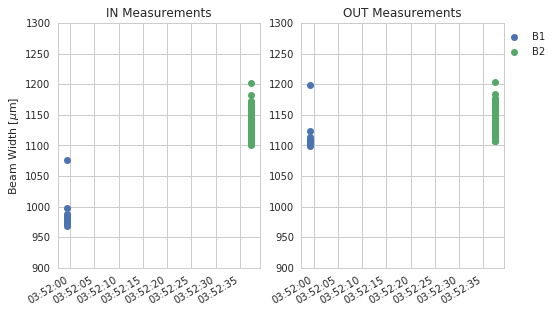

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))

testdf_b1 = scandf[(scandf['FILL']== fill_num) & (scandf['PLANE']==plane) & (scandf['BEAM']=='B1')]
testdf_b2 = scandf[(scandf['FILL']== fill_num) & (scandf['PLANE']==plane) & (scandf['BEAM']=='B2')]

testdf_b1['BEAM_WIDTH_IN'].plot(ax=axes[0], linestyle="", marker="o", ylim=[900,1300], label='B1')
testdf_b2['BEAM_WIDTH_IN'].plot(ax=axes[0], linestyle="", marker="o", ylim=[900,1300], label='B2')
testdf_b1['BEAM_WIDTH_OUT'].plot(ax=axes[1], linestyle="", marker="o", ylim=[900,1300], label='B1')
testdf_b2['BEAM_WIDTH_OUT'].plot(ax=axes[1], linestyle="", marker="o", ylim=[900,1300], label='B2')

axes[0].set_ylabel(r'Beam Width [$\mu$m]')
axes[0].set_title('IN Measurements')
axes[1].set_title('OUT Measurements')
axes[1].legend(loc = 9, bbox_to_anchor = (1.1, 1))
plt.savefig('wire_mes_func_time.pdf', bbox_inches='tight')


$\sigma_{IN}$ and $\sigma_{OUT}$ measurements for both B1 and B2 are shown. From the plot, it is clear that one vertical wire scanner measurement was made for each beam during injection. The multitude of points at each time correspond to all the different bunches.